**Przyjęte workflow:**
- Wstępna eksploracja danych
- Usunięcie kolumn i wierszy (nadmiarowych oraz z dużą liczbą NANów)
- Imputacja wartości odstających
- Imputacja brakujących wartości 
- Podział zbioru na zbiory treningowy oraz walidacyjny
- Zbalansowanie danych z wykorzystaniem SMOTE
- Standaryzacja i PCA
- Trening modelu z regularyzacją
- Ewaluacja wyników
- Predykcja na zbiorze testowym

**Przygotowanie środowiska**

In [2]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 3.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 41.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.1
    Uninstalling scikit-learn-1.3.1:
      Successfully uninstalled scikit-learn-1.3.1
Note: you may need to restart the kernel to use updated packages.


In [74]:
# importing libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, conv, when, trim
from pyspark.sql.types import IntegerType, LongType
from IPython.display import display
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator 
from pyspark.ml import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [88]:
spark.stop()

In [24]:
# building spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "30g") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.local.dir", "/tmp/spark-temp") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.shuffle.partitions", "400") \
    .getOrCreate()
spark

**Wczytanie danych**

In [9]:
# columns = ["Label", "I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", 
#            "I10", "I11", "I12", "I13", "C1", "C2", "C3", "C4", "C5", "C6", 
#            "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", 
#            "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26"]

# df = (
#     spark.read
#     .option("sep", "\t") 
#     .option("inferSchema", "true")  
#     .csv("../Dane/criteo-dataset/dac/train.txt") 
#     # "D:\coding\Kamila\Dane\criteo-dataset\dac\train.txt"
#     #work/Dane/criteo-dataset/dac/train.txt
# )

# df = df.toDF(*columns)

# df.printSchema()

root
 |-- Label: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string 

In [10]:
# df.write.mode("overwrite").parquet("output_parquet")

In [25]:
# conversion to parquet format with given limit

# limit = 2000000
data = spark.read.parquet("output_parquet")
# data=data.limit(limit) #sample musi być
data = data.sample(fraction=0.05)
data = data.repartition(64) # podział na partycje żeby przyspieszyć
dataPd = data.toPandas() 

# display the first few rows of the data
dataPd.head()

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,NaN,46,8.0,2.0,150472.0,NaN,0.0,2.0,2.0,...,1e88c74f,582152eb,21ddcdc9,5840adea,None,c9d4222a,32c7478e,None,001f3601,56be3401
1,0,7.0,1,36.0,28.0,181.0,37.0,16.0,29.0,34.0,...,e5ba7672,9880032b,21ddcdc9,5840adea,53b6d8fb,None,55dd3565,17de96b7,ea9a246c,dda91ee8
2,0,NaN,3,31.0,30.0,8735.0,94.0,6.0,39.0,86.0,...,e5ba7672,be645006,21ddcdc9,5840adea,2754aaf1,ad3062eb,55dd3565,3b183c5c,001f3601,7257f019
3,0,0.0,2,NaN,2.0,29414.0,1016.0,4.0,2.0,106.0,...,3486227d,e161d23a,None,None,None,None,32c7478e,None,None,None
4,0,NaN,13,49.0,95.0,27.0,95.0,5.0,49.0,95.0,...,e5ba7672,5b5794f1,None,None,None,None,32c7478e,None,None,None


In [26]:
print("Number of rows:")
print(data.count())

print("\nColumn Names:")
print(data.columns)

Number of rows:
2289077

Column Names:
['Label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


**Wstępna eksploracja danych**

In [27]:
# missing values

number_of_rows = data.count()

for column in data.columns:
    count_null = data.filter(col(column).isNull()).count()
    percentage_null = (count_null / number_of_rows) * 100
    print(f"Column '{column}' has {percentage_null:.2f}% NULL values.")

Column 'Label' has 0.00% NULL values.
Column 'I1' has 45.41% NULL values.
Column 'I2' has 0.00% NULL values.
Column 'I3' has 21.39% NULL values.
Column 'I4' has 21.66% NULL values.
Column 'I5' has 2.58% NULL values.
Column 'I6' has 22.38% NULL values.
Column 'I7' has 4.31% NULL values.
Column 'I8' has 0.05% NULL values.
Column 'I9' has 4.31% NULL values.
Column 'I10' has 45.41% NULL values.
Column 'I11' has 4.31% NULL values.
Column 'I12' has 76.47% NULL values.
Column 'I13' has 21.66% NULL values.
Column 'C1' has 0.00% NULL values.
Column 'C2' has 0.00% NULL values.
Column 'C3' has 3.40% NULL values.
Column 'C4' has 3.40% NULL values.
Column 'C5' has 0.00% NULL values.
Column 'C6' has 12.06% NULL values.
Column 'C7' has 0.00% NULL values.
Column 'C8' has 0.00% NULL values.
Column 'C9' has 0.00% NULL values.
Column 'C10' has 0.00% NULL values.
Column 'C11' has 0.00% NULL values.
Column 'C12' has 3.40% NULL values.
Column 'C13' has 0.00% NULL values.
Column 'C14' has 0.00% NULL values.


In [28]:
# outliers

numeric_cols = [col_name for col_name, dtype in data.dtypes if dtype in ("int", "double", "float")]
stat_list = []
for col in numeric_cols:
    stat_list.append(F.min(col).alias(f"{col}_min"))
    stat_list.append(F.max(col).alias(f"{col}_max"))
    stat_list.append(F.avg(col).alias(f"{col}_avg"))
    stat_list.append(F.stddev(col).alias(f"{col}_std"))

summary_stats = data.select(*stat_list)

summary_stats_pandas = summary_stats.toPandas()

third_len = len(summary_stats_pandas.columns) // 3

df_part1 = summary_stats_pandas.iloc[:, :third_len]  # Pierwsza część
df_part2 = summary_stats_pandas.iloc[:, third_len:2*third_len]  # Druga część
df_part3 = summary_stats_pandas.iloc[:, 2*third_len:]  # Trzecia część

styled_part1 = df_part1.style \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_properties(**{'text-align': 'center'})

styled_part2 = df_part2.style \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_properties(**{'text-align': 'center'})

styled_part3 = df_part3.style \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_properties(**{'text-align': 'center'})

display(styled_part1)  
display(styled_part2)  
display(styled_part3)

,Label_min,Label_max,Label_avg,Label_std,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I3_min,I3_max,I3_avg,I3_std,I4_min,I4_max
0,0,1,0.255511,0.436148,0,2047,3.514791,9.556120,-3,27673,105.789756,391.061748,0,65535,26.886572,392.570772,0,969


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std,I7_min,I7_max,I7_avg,I7_std,I8_min,I8_max,I8_avg,I8_std
0,7.330218,8.880876,0,2632275,18569.780451,69492.913900,0,367553,116.335423,437.623023,0,6811,16.296015,63.332079,0,5180,12.534287,17.261824


,I9_min,I9_max,I9_avg,I9_std,I10_min,I10_max,I10_avg,I10_std,I11_min,I11_max,I11_avg,I11_std,I12_min,I12_max,I12_avg,I12_std,I13_min,I13_max,I13_avg,I13_std
0,0,17111,106.184452,220.637161,0,8,0.618575,0.684772,0,160,2.730571,5.196490,0,689,0.990698,5.190064,0,4685,8.237227,16.544639


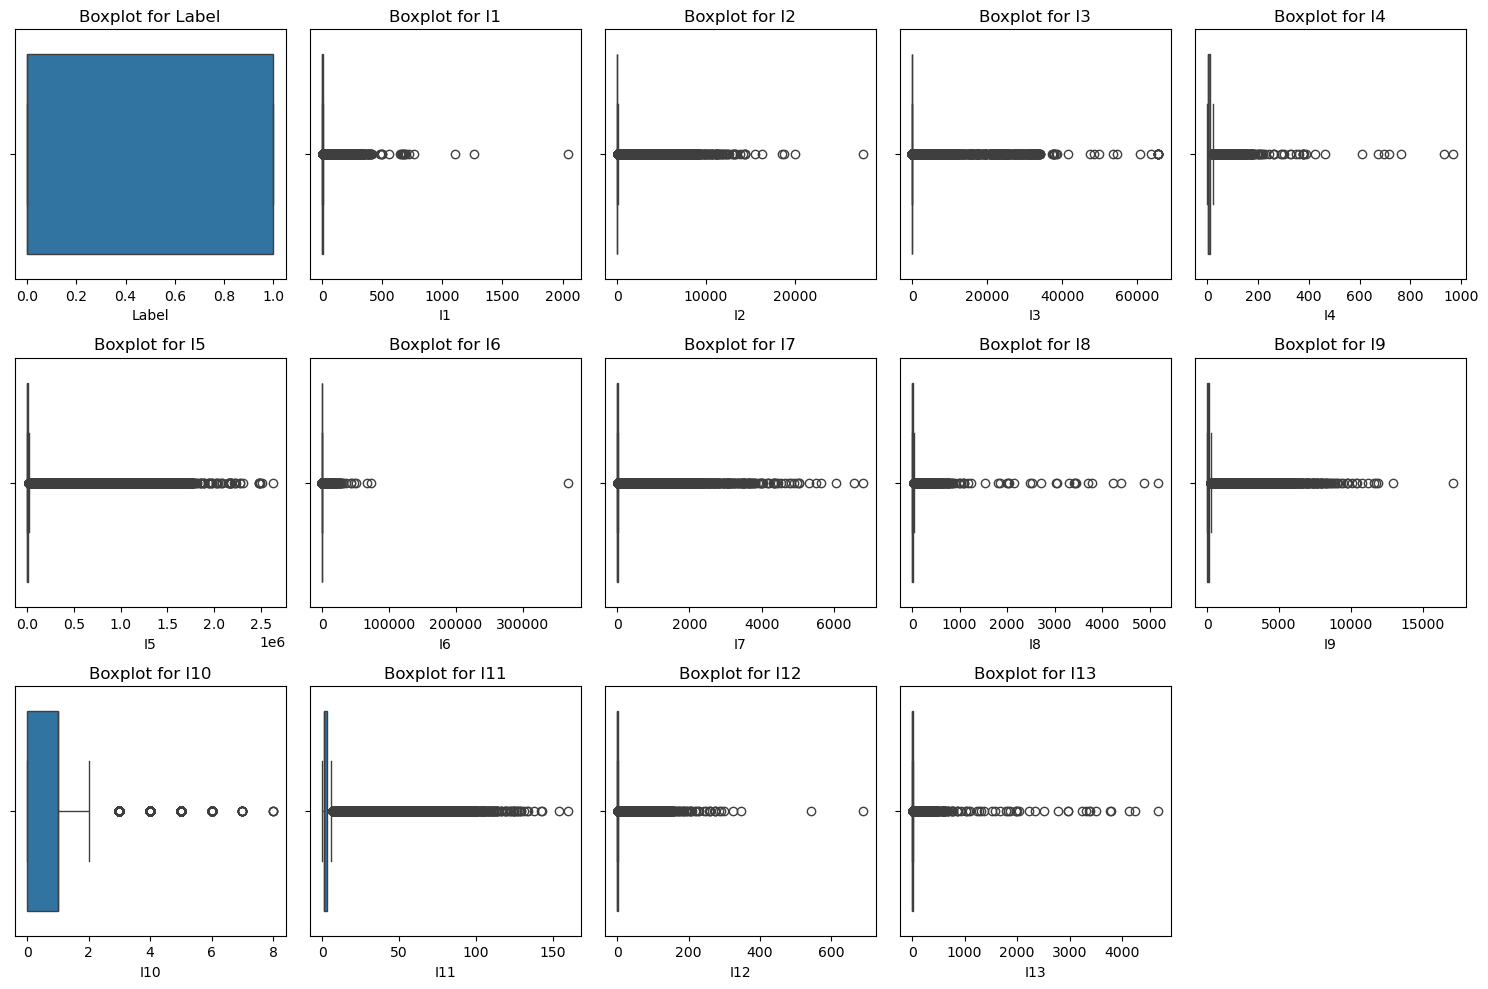

In [29]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//5 + 1, 5, i + 1) 
    sns.boxplot(data=dataPd, x=col, orient="h")
    plt.title(f"Boxplot for {col}")

plt.tight_layout()
plt.show()

Column 'Label': 2 unique values
Column 'I1': 321 unique values
Column 'I2': 5022 unique values
Column 'I3': 2730 unique values
Column 'I4': 201 unique values
Column 'I5': 125605 unique values
Column 'I6': 4956 unique values
Column 'I7': 1818 unique values
Column 'I8': 460 unique values
Column 'I9': 3805 unique values
Column 'I10': 9 unique values
Column 'I11': 136 unique values
Column 'I12': 188 unique values
Column 'I13': 435 unique values
Column 'C1': 1409 unique values
Column 'C2': 553 unique values
Column 'C3': 752501 unique values
Column 'C4': 257915 unique values
Column 'C5': 299 unique values
Column 'C6': 17 unique values
Column 'C7': 11742 unique values
Column 'C8': 622 unique values
Column 'C9': 3 unique values
Column 'C10': 42459 unique values
Column 'C11': 5127 unique values
Column 'C12': 661407 unique values
Column 'C13': 3169 unique values
Column 'C14': 26 unique values
Column 'C15': 10919 unique values
Column 'C16': 489342 unique values
Column 'C17': 10 unique values
Colu

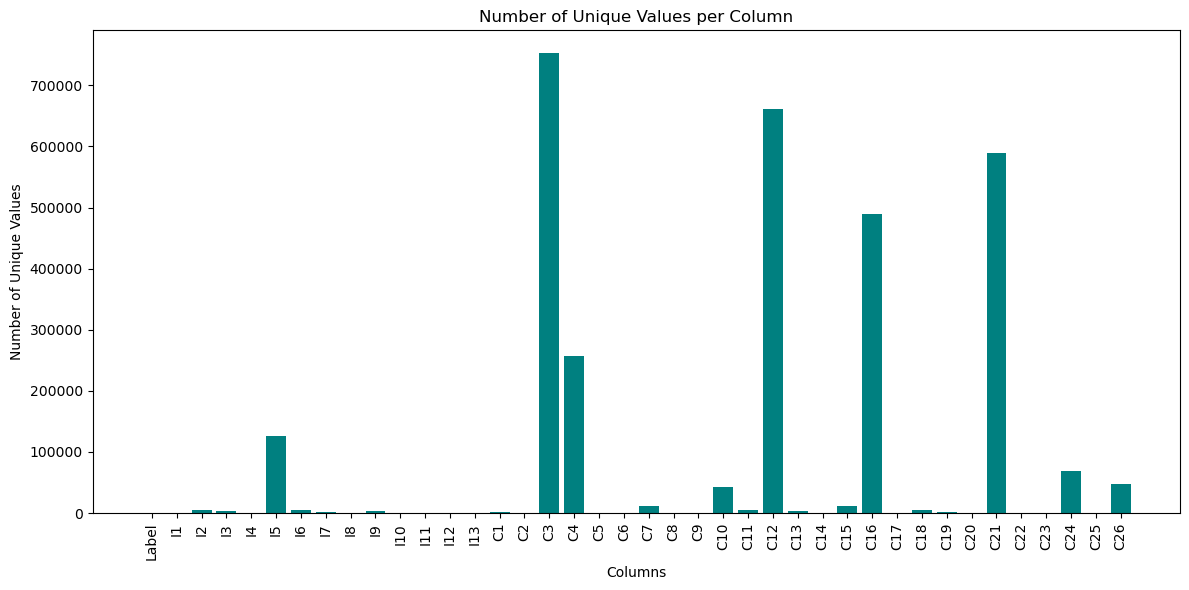

In [30]:
# cardinality of the features

unique_counts = []

for column in data.columns:
    unique_count = data.select(F.countDistinct(F.col(column))).collect()[0][0]  
    unique_counts.append((column, unique_count))
    print(f"Column '{column}': {unique_count} unique values")

unique_counts_df = pd.DataFrame(unique_counts, columns=['Column', 'Unique Count'])

plt.figure(figsize=(12, 6))
plt.bar(unique_counts_df['Column'], unique_counts_df['Unique Count'], color='teal')
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values per Column')
plt.tight_layout()
plt.show()

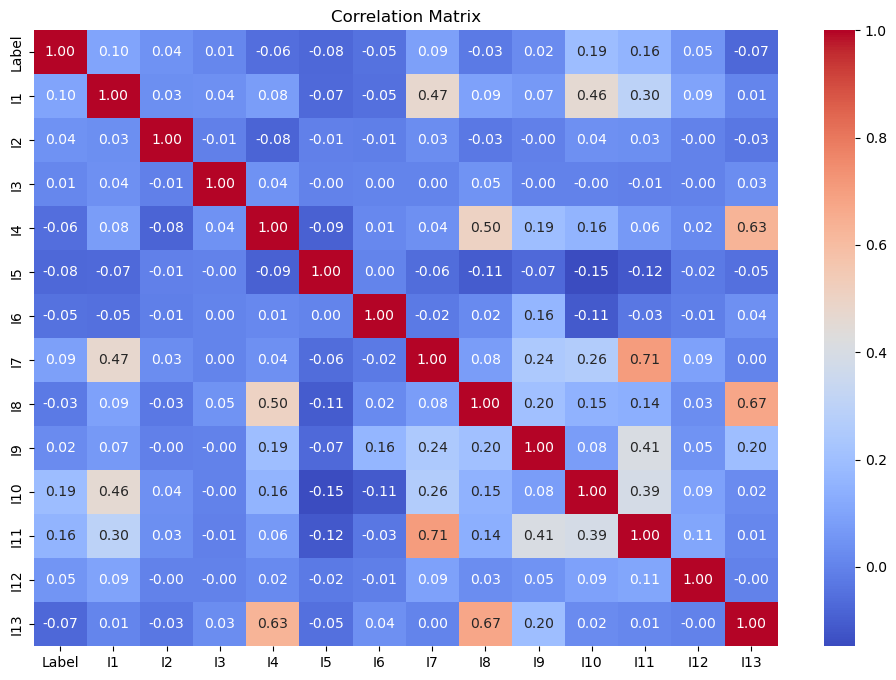

In [31]:
# correlation matrix

numeric_cols = [col_name for col_name, dtype in data.dtypes if dtype in ("int", "double", "float")]

correlation_matrix = pd.DataFrame(columns=numeric_cols, index=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        correlation_matrix.loc[col1, col2] = data.stat.corr(col1, col2) 

correlation_matrix = correlation_matrix.astype(float)  

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

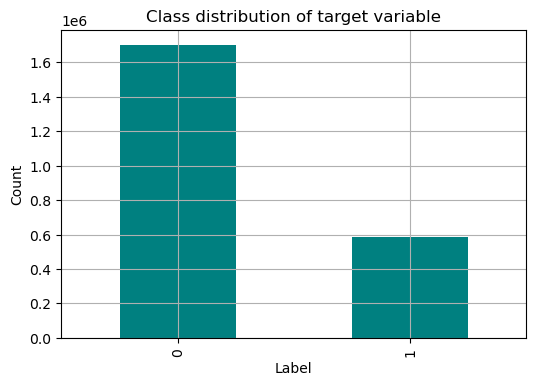

Percentage distribution of the target:
 Label
0    74.448915
1    25.551085
Name: proportion, dtype: float64


In [32]:
# class distribution
y = dataPd['Label']

plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar', color= 'teal')
plt.title('Class distribution of target variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()

class_distribution = y.value_counts(normalize=True) * 100
print("Percentage distribution of the target:\n", class_distribution)

**Konwersja wartości szesnastkowych na liczby dziesiętne**

In [33]:
def convert_hex_to_num(df):
    for column in df.columns:
        if dict(df.dtypes)[column] == 'string':
            df = df.withColumn(
                column,
                F.when(
                    F.trim(F.col(column)).rlike('^[0-9A-Fa-f]+$'),
                    F.conv(F.trim(F.col(column)), 16, 10).cast(LongType())
                ).otherwise(None)
            )
    return df

In [34]:
data = convert_hex_to_num(data)
data.printSchema()

root
 |-- Label: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: long (nullable = true)
 |-- C2: long (nullable = true)
 |-- C3: long (nullable = true)
 |-- C4: long (nullable = true)
 |-- C5: long (nullable = true)
 |-- C6: long (nullable = true)
 |-- C7: long (nullable = true)
 |-- C8: long (nullable = true)
 |-- C9: long (nullable = true)
 |-- C10: long (nullable = true)
 |-- C11: long (nullable = true)
 |-- C12: long (nullable = true)
 |-- C13: long (nullable = true)
 |-- C14: long (nullable = true)
 |-- C15: long (nullable = true)
 |-- C16: lo

**Usunięcie kolumn i wierszy (nadmiarowych oraz z dużą liczbą NANów)**

In [35]:
columns_to_drop = ['I12', 'C22']
columns_strongly_correlated = ['I3', 'I8', 'I9']

In [36]:
columns_to_drop_all = columns_to_drop + columns_strongly_correlated 
data_cleaned = data.drop(*columns_to_drop_all)
data_cleaned = data_cleaned.na.drop(how="all")
print(data_cleaned.columns)

['Label', 'I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


**Imputacja wartości odstających**

In [37]:
def handle_outliers(df, numeric_cols, method="iqr", action="cap", z_thresh=3.0, iqr_multiplier=1.5, threshold_ratio=0.2):
    updated_df = df

    for col in numeric_cols:
        stats = df.selectExpr(
            f'percentile({col}, array(0.25, 0.5, 0.75)) as percentiles',
            f'mean({col}) as mean',
            f'stddev({col}) as stddev'
        ).first()

        q1, median, q3 = stats['percentiles']
        mean, stddev = stats['mean'], stats['stddev']
        iqr = q3 - q1
        lower_iqr, upper_iqr = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
        lower_z, upper_z = mean - z_thresh * stddev, mean + z_thresh * stddev

        lower, upper = (lower_iqr, upper_iqr) if method == "iqr" else (lower_z, upper_z)

        total_count = df.filter(F.col(col).isNotNull()).count()
        outlier_count = df.filter((F.col(col) < lower) | (F.col(col) > upper)).count()
        outlier_ratio = outlier_count / total_count if total_count else 0

        if outlier_ratio == 0:
            continue

        if outlier_ratio > threshold_ratio:
            print(f"Skipping {col} due to high outlier ratio.")
            continue

        if action == "remove":
            updated_df = updated_df.filter((F.col(col) >= lower) & (F.col(col) <= upper))
        elif action == "impute":
            updated_df = updated_df.withColumn(
                col,
                F.when((F.col(col) < lower) | (F.col(col) > upper), median).otherwise(F.col(col))
            )
        elif action == "cap":
            updated_df = updated_df.withColumn(
                col,
                F.when(F.col(col) < lower, lower)
                 .when(F.col(col) > upper, upper)
                 .otherwise(F.col(col))
            )
        else:
            raise ValueError("Invalid action: choose from 'cap', 'remove', 'impute'.")

    return updated_df

def generate_outlier_handling_datasets(df, numeric_cols):
    # methods = ["iqr", "z-score"]
    # actions = ["cap", "remove", "impute"]
    methods = ["iqr"]
    actions = ["cap"]

    results = {}
    
    for method in methods:
        for action in actions:
            print(f"\nMethod: {method.upper()}, Action: {action.upper()}")
            handled_df = handle_outliers(
                df=df,
                numeric_cols=numeric_cols,
                method=method,
                action=action,
                z_thresh=3.0,
                iqr_multiplier=1.5,
                threshold_ratio=0.2
            )
            label = f"{method}_{action}"
            results[label] = handled_df
            # display_summary(handled_df, f"After Outlier Handling - Method: {method.upper()}, Action: {action.upper()}")

    return results

In [38]:
numeric_cols = [col_name for col_name, dtype in data_cleaned.dtypes if dtype in ("int", "double", "float")]
# report_outliers_dual(data_cleaned, numeric_cols)

data_no_outliers = generate_outlier_handling_datasets(data_cleaned, numeric_cols)


Method: IQR, Action: CAP


**Imputacja brakujących wartości**

In [39]:
def get_mode(df, column):
    mode_df = df.groupBy(column).count().orderBy(F.desc("count"))
    if mode_df.filter(F.col(column).isNotNull()).count() > 0:
        return mode_df.filter(F.col(column).isNotNull()).first()[column]
    return None

def impute_all_datasets(modified_versions, columns_to_imputate_rand):
    results = {}

    for name, df in modified_versions.items():
        print(f"\n--- Imputing Dataset: {name} ---")
        current_df = df

        existing_columns = set(current_df.columns)
        numeric_columns = [col for col in columns_to_imputate_rand if col.startswith('I') and col in existing_columns]
        categorical_columns = [col for col in columns_to_imputate_rand if col.startswith('C') and col in existing_columns]

        modes = {col: get_mode(current_df, col) for col in categorical_columns}

        # Fill categorical columns
        for col in categorical_columns:
            if modes[col] is not None:
                current_df = current_df.withColumn(
                    col, 
                    F.when(F.col(col).isNull(), modes[col]).otherwise(F.col(col))
                )

        # Apply median imputation to numeric columns
        if numeric_columns:
            imputer = Imputer(
                inputCols=numeric_columns,
                outputCols=numeric_columns,
                strategy="median"
            )
            imputer_model = imputer.fit(current_df)
            current_df = imputer_model.transform(current_df)

        # Final null check
        for col in columns_to_imputate_rand:
            if col in current_df.columns and current_df.filter(F.col(col).isNull()).count() > 0:
                print(f"Column {col} in {name} still has NULL values!")

        results[name] = current_df

    return results

In [40]:
columns_to_imputate = ['I1', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I13', 'C3', 'C4', 'C6', 'C12', 'C16', 'C19', 'C20', 'C21', 'C24', 'C25', 'C26']

data_no_missing_values= impute_all_datasets(data_no_outliers, columns_to_imputate)


--- Imputing Dataset: iqr_cap ---


In [41]:
def evaluate_outlier_handling(original_df, modified_dfs: dict, numeric_cols: list):
    from pyspark.sql.functions import avg, stddev

    results = []
    original_count = original_df.count()

    for method_action, df in modified_dfs.items():
        row_count = df.count()
        row_retention = row_count / original_count

        stats = df.select(
            *[avg(c).alias(f"{c}_avg") for c in numeric_cols] +
            [stddev(c).alias(f"{c}_std") for c in numeric_cols]
        ).toPandas()

        avg_mean = stats.loc[0, [c for c in stats.columns if c.endswith("_avg")]].mean()
        avg_std = stats.loc[0, [c for c in stats.columns if c.endswith("_std")]].mean()

        results.append({
            "Method_Action": method_action.replace("_", " ").title(),
            "Rows Retained (%)": round(row_retention * 100, 2),
            "Average Mean": round(avg_mean, 4),
            "Average StdDev": round(avg_std, 4),
        })

    return pd.DataFrame(results).sort_values("Rows Retained (%)", ascending=False)


In [42]:
evaluation_result = evaluate_outlier_handling(data_cleaned, data_no_missing_values, numeric_cols)
display(evaluation_result.style.background_gradient(cmap='viridis'))

,Method_Action,Rows Retained (%),Average Mean,Average StdDev
0,Iqr Cap,100.000000,694.344100,868.518500


In [43]:
# final dataset
print("Number of rows:")
print(data_no_missing_values["iqr_cap"].count())

print("\nColumn Names:")
print(data_no_missing_values["iqr_cap"].columns)


Number of rows:
2289077

Column Names:
['Label', 'I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [44]:
# saving the cleaned dataset to parquet format

data_no_missing_values["iqr_cap"].write.mode("overwrite").parquet("dataset_no_missing_values")

In [15]:
# data_cleaned.write.mode("overwrite").parquet("data_cleaned")

In [ ]:
# data_no_outliers["iqr_cap"].write.mode("overwrite").parquet("dataset_no_outliers_iqr_cap")

In [45]:
# loading the cleaned dataset from parquet format
data_no_missing_values = spark.read.parquet("dataset_no_missing_values")

# displaying the first few rows of the cleaned dataset
data_no_missing_values.limit(5).toPandas()

,Label,I1,I2,I4,I5,I6,I7,I10,I11,I13,...,C16,C17,C18,C19,C20,C21,C23,C24,C25,C26
0,1,1.0,87.5,4.0,24847.5,208.0,1.0,1.0,1.0,4.0,...,2706241271,512280399,135613171,568184265,1480633834,3891316444,851920782,1043370398,4116448438,804119890
1,0,1.0,68.0,4.0,4177.0,53.0,24.0,1.0,6.0,4.0,...,3548315276,881205885,2650054349,568184265,1480633834,3054605081,3686041303,1168872648,3406273581,2973715166
2,0,1.0,55.0,8.0,21.0,32.0,0.0,1.0,0.0,6.0,...,2223606570,2003624857,1478578923,568184265,1480633834,1360682,974593739,1071331371,2045441,2858355221
3,0,1.0,-1.0,4.0,2809.0,32.0,3.0,1.0,1.0,4.0,...,1926330639,537242577,4030630661,568184265,2972002973,2500694465,851920782,796825822,2045441,1238795398
4,0,1.0,-1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,4172497942,3569056728,4248377849,568184265,1480633834,4091401497,974593739,3008311592,1917519066,2858355221


**Podział zbioru na zbióry treningowy oraz walidacyjny**

In [46]:
train_data, val_data = data_no_missing_values.randomSplit([0.8, 0.2], seed=42)
train_data_pd = train_data.toPandas()

X_train = train_data.drop('Label')
y_train = train_data.select('Label')

X_train_pd = train_data_pd.drop(columns= ['Label'])
y_train_pd = train_data_pd['Label']

**Zbalansowanie danych z wykorzystaniem SMOTE**

In [47]:
print(f"We're using' a sample of {X_train_pd.shape[0]} records for SMOTE")
smote = SMOTE(k_neighbors=3, sampling_strategy=1.0, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pd, y_train_pd)

data_balanced_pd = pd.DataFrame(X_train_smote, columns= X_train_pd.columns)
data_balanced_pd['Label'] = y_train_smote

data_balanced = spark.createDataFrame(data_balanced_pd)

We're using' a sample of 1830610 records for SMOTE


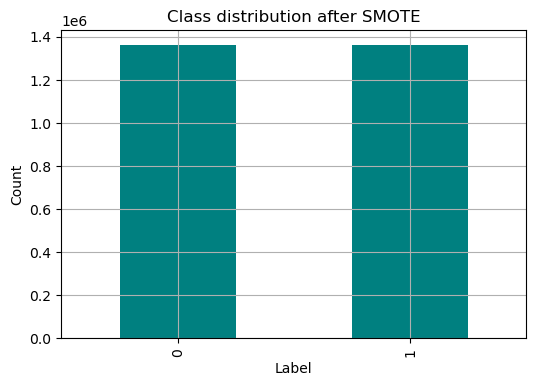

Percentage class distribution after SMOTE:
 Label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [50]:
plt.figure(figsize=(6,4))
# data_balanced_pd['Label'].value_counts().plot(kind='bar', colorbar= 'teal')
data_balanced_pd['Label'].value_counts().plot(kind='bar', color='teal')
plt.title('Class distribution after SMOTE')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()

class_distribution = data_balanced_pd['Label'].value_counts(normalize=True) * 100
print("Percentage class distribution after SMOTE:\n", class_distribution)

**Standaryzacja i PCA**

In [51]:
numeric_cols = [col for col in data_balanced.columns if col != "Label"]  
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")


scaler = StandardScaler(inputCol="features", 
                             outputCol="scaledFeatures",
                             withStd=True, 
                             withMean=True)

In [52]:
pipeline_pca = Pipeline(stages=[assembler, scaler])
scaler_model = pipeline_pca.fit(data_balanced) 
scaled_data= scaler_model.transform(data_balanced) 

In [53]:
num_features = len(numeric_cols)
pca_model_selection= PCA(k=num_features, inputCol="scaledFeatures", outputCol="pcaFeatures").fit(scaled_data)

explained_variance = pca_model_selection.explainedVariance
cumulative_variance = []
total_variance = 0.0
for variance in explained_variance:
    total_variance += float(variance)
    cumulative_variance.append(total_variance)

In [54]:
print(len(cumulative_variance))

34


In [55]:
best_k = next(i + 1 for i, cum_var in enumerate(cumulative_variance) if cum_var >= 0.90)
# best_k = 28 # około 90% wyjaśnialności, dla 30 komponentów było 95% 

print(f"Dobrana liczba komponentów (k): {best_k}")
print(f"Sumaryczna wyjaśnialność wariancji: {cumulative_variance[best_k - 1]:.4f}")

Dobrana liczba komponentów (k): 27
Sumaryczna wyjaśnialność wariancji: 0.9113


In [56]:
pca = PCA(k=best_k, inputCol="scaledFeatures", outputCol="pcaFeatures")  # k=10 oznacza 10 głównych komponentów

**Trening modelu z regularyzacją**

In [57]:
lr = LogisticRegression(featuresCol="pcaFeatures", labelCol="Label", elasticNetParam= 0.0, regParam=0.01)
pipeline = Pipeline(stages=[assembler, scaler, pca, lr])

In [58]:
model = pipeline.fit(data_balanced) 

In [59]:
print(f"Model coefficients: {model.stages[3].coefficients}")
print(f"Model intercept: {model.stages[3].intercept}")

Model coefficients: [-0.3453217605143408,-0.2823403048617954,0.13652113357220816,0.1362234871021608,-0.0034554417363960826,0.019028825524014963,-0.09203930867457094,0.05207844257592793,0.013489347650442522,0.031829547239596946,-0.0265095423105597,-0.07577837941623117,0.04681779751513879,-0.008861395646231398,0.013680616232370124,-0.016423207340546392,-0.06595615196322531,-0.010717287989294702,0.023925818595070612,0.019624218632006588,0.06565239846241047,-0.005558152354095433,-0.04872143417983115,-0.02847480719072588,0.006946772941632044,-0.030205268619826725,0.023556177723016183]
Model intercept: 0.0042837168089847185


In [60]:
pca_model = model.stages[2]  # model PCA jest na etapie 2 w pipeline
print(f"Explained Variance by PCA: {pca_model.explainedVariance.sum()}")

Explained Variance by PCA: 0.9112598071428355


In [61]:
val_predictions = model.transform(val_data)

In [62]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(val_predictions)
print(f"Validation F1-score: {f1_score:.4f}")

Validation F1-score: 0.6772


In [63]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(val_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.6576


**Ewaluacja wyników**

In [64]:
def evaluate_stage(
    train_df, 
    val_df, 
    label_col="Label", 
    features_col="features", 
    input_cols=None, 
    model=None
):
    if model is None:
        model = LogisticRegression(featuresCol=features_col, labelCol=label_col)

    if input_cols and features_col not in train_df.columns:
        assembler = VectorAssembler(inputCols=input_cols, outputCol=features_col)
        train_df = assembler.transform(train_df)
        val_df = assembler.transform(val_df)

    model_fitted = model.fit(train_df)
    pred = model_fitted.transform(val_df)

    evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")
    evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    f1 = evaluator_f1.evaluate(pred)
    acc = evaluator_acc.evaluate(pred)
    return f1, acc


In [65]:
results = []

# 0. before any processing
data_raw = data.na.drop()
train_data_raw, val_data_raw = data_raw.randomSplit([0.8, 0.2], seed=42)

f1_initial, acc_initial = evaluate_stage(
    train_data_raw,
    val_data_raw,
    input_cols=[col for col in train_data.columns if col != 'Label']
)
results.append(("Initial Data", f1_initial, acc_initial))

In [66]:
# 1. after removing outliers and missing values
f1_imp, acc_imp = evaluate_stage(
    train_data,
    val_data,
    input_cols=[col for col in train_data.columns if col != 'Label']
)
results.append(("Cleaned data", f1_imp, acc_imp))


In [67]:
# 2. after balancing with SMOTE
f1_smote, acc_smote = evaluate_stage(
    data_balanced,
    val_data,
    input_cols=[col for col in data_balanced.columns if col != 'Label']
)
results.append(("Data balanced with SMOTE", f1_smote, acc_smote))


In [68]:
# 3. after PCA 
pipeline_pca = Pipeline(stages=[assembler, scaler, pca])#na data no missing values
pipeline_pca_model = pipeline_pca.fit(data_balanced)

train_pca = pipeline_pca_model.transform(data_balanced)
val_pca = pipeline_pca_model.transform(val_data)

f1_pca, acc_pca = evaluate_stage(
    train_pca,
    val_pca,
    input_cols=[], 
    features_col="pcaFeatures"
)
results.append(("Data reduced with PCA", f1_pca, acc_pca))


In [69]:
print("Summary evaluation (F1, Accuracy):")
for stage, f1, acc in results:
    print(f"{stage}: F1 = {f1:.4f}, Accuracy = {acc:.4f}")

Summary evaluation (F1, Accuracy):
Initial Data: F1 = 0.6181, Accuracy = 0.6974
Cleaned data: F1 = 0.6995, Accuracy = 0.7553
Data balanced with SMOTE: F1 = 0.6806, Accuracy = 0.6613
Data reduced with PCA: F1 = 0.6772, Accuracy = 0.6576


**Predykcja na zbiorze testowym**

Przygotowanie danych testowych

In [70]:
columns = ["I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", 
           "I10", "I11", "I12", "I13", "C1", "C2", "C3", "C4", "C5", "C6", 
           "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", 
           "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26"]

df_test = (
    spark.read
    .option("sep", "\t") 
    .option("inferSchema", "true")  
    .csv("../Dane/criteo-dataset/dac/test.txt") 
)

df_test = df_test.toDF(*columns)

df_test.printSchema()

print(f"Liczba wierszy: {df_test.count()}")

root
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nu

In [71]:
df_test.write.mode("overwrite").parquet("output_perquet_test")

In [72]:
data_test = spark.read.parquet("output_perquet_test")

In [75]:
for column in data_test.columns:
    if dict(data_test.dtypes)[column] == 'string':
        data_test = data_test.withColumn(
            column,
            when(trim(col(column)).rlike('^[0-9A-Fa-f]+$'), conv(trim(col(column)), 16, 10).cast(LongType()))
            .otherwise(None)  
        )
data.printSchema()

root
 |-- Label: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: long (nullable = true)
 |-- C2: long (nullable = true)
 |-- C3: long (nullable = true)
 |-- C4: long (nullable = true)
 |-- C5: long (nullable = true)
 |-- C6: long (nullable = true)
 |-- C7: long (nullable = true)
 |-- C8: long (nullable = true)
 |-- C9: long (nullable = true)
 |-- C10: long (nullable = true)
 |-- C11: long (nullable = true)
 |-- C12: long (nullable = true)
 |-- C13: long (nullable = true)
 |-- C14: long (nullable = true)
 |-- C15: long (nullable = true)
 |-- C16: lo

In [76]:
columns_to_drop = ['I12', 'C22']
columns_strongly_correlated = ['I3', 'I8', 'I9']

In [77]:
columns_to_drop_all = columns_to_drop + columns_strongly_correlated # z korelacji
data_cleaned_test = data_test.drop(*columns_to_drop_all)
data_cleaned_test = data_cleaned_test.na.drop(how="all")
print(data_cleaned_test.columns)

['I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [78]:
numeric_cols_test = [col_name for col_name, dtype in data_cleaned_test.dtypes if dtype in ("int", "double", "float")]
# report_outliers_dual(data_cleaned, numeric_cols)

data_no_outliers_test = generate_outlier_handling_datasets(data_cleaned_test, numeric_cols_test)


Method: IQR, Action: CAP


In [79]:
columns_to_imputate = ['I1', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I13', 'C3', 'C4', 'C6', 'C12', 'C16', 'C19', 'C20', 'C21', 'C24', 'C25', 'C26']

data_no_missing_values_test= impute_all_datasets(data_no_outliers_test, columns_to_imputate)


--- Imputing Dataset: iqr_cap ---


In [81]:
print(data_no_missing_values_test["iqr_cap"].columns)

['I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [83]:
data_no_missing_values_test["iqr_cap"].write.mode("overwrite").parquet("data_no_missing_values_test")

In [84]:
data_no_missing_values_test = spark.read.parquet("data_no_missing_values_test")

In [85]:
print(data_no_missing_values_test.columns)

['I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [86]:
input_cols = model.stages[0].getInputCols()  
# print(input_cols)
data_no_missing_values_test = data_no_missing_values_test.select(input_cols) 

test_predictions = model.transform(data_no_missing_values_test)

test_predictions.select("features", "prediction").show(100)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.0,29.0,5.0,726...|       0.0|
|[7.5,17.0,22.0,2....|       0.0|
|[1.0,1.0,7.0,1.0,...|       1.0|
|[4.0,1.0,6.0,1051...|       0.0|
|[7.0,1.0,10.0,139...|       1.0|
|[7.5,11.0,9.0,316...|       1.0|
|[2.0,1.0,4.0,7.0,...|       0.0|
|[1.0,0.0,4.0,8906...|       0.0|
|[1.0,4.0,5.0,2780...|       0.0|
|[7.5,0.0,22.0,457...|       1.0|
|[1.0,4.0,20.0,177...|       0.0|
|[1.0,52.0,22.0,15...|       0.0|
|[1.0,1.0,4.0,2447...|       0.0|
|[7.5,18.0,8.0,0.0...|       1.0|
|[1.0,2.0,4.0,508....|       0.0|
|[1.0,87.5,4.0,244...|       0.0|
|[1.0,18.0,8.0,0.0...|       0.0|
|[1.0,3.0,4.0,2447...|       0.0|
|[7.5,11.0,6.0,2.0...|       1.0|
|[1.0,3.0,19.0,244...|       0.0|
|[0.0,37.0,5.0,596...|       0.0|
|[0.0,43.0,21.0,21...|       0.0|
|[1.0,14.0,4.0,131...|       0.0|
|[0.0,-1.0,17.0,15...|       0.0|
|[0.0,87.5,0.0,466...|       0.0|
|[0.0,69.0,15.0,43...|       0.0|
|[2.0,87.5,3.0

In [87]:
result = test_predictions.agg(
    (F.count(F.when(F.col("prediction") == 1, 1)) / F.count("*") * 100).alias("percentage_1")
).collect()[0]["percentage_1"]

print(f"Prediction percantage == 1: {result:.2f}%")

Prediction percantage == 1: 41.80%
